# Лабораторная работа 4. Глубокое обучение с подкреплением. Deep Q-Network (DQN)


В прошлой лабораторной работе мы увидели процесс обучения агентов путем оптимизации функции полезности (Q). Этот подход гарантированно работает, а при правильном подборе параметров дает приемлимые результаты

Однако в реальных окружениях зачастую пространство состояний слишком большое, в результате чего табличный подход к представлению функции Q теряет свою актуальность. На помощь приходят глубокие нейронные сети, которые могут предсказывать значения полезности для каждого действия.

### Важно!
Мы используем версию gym 0.25.1. В случае установки из pip более свежей версии возможны изменения в вызовах методов библиотеки. Актуально для тех, кто работает в PyCharm.

Установка зависимостей для визуализации окружений в Google Colab.

In [ ]:
!apt-get install -y xvfb python-opengl
!pip install gym pyvirtualdisplay
!pip install pygame

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Импортируем библиотеку OpenAI Gym и зависимость для работы с дисплеем

In [ ]:
from IPython import display as ipythondisplay
import gym
import matplotlib.pyplot as plt
import numpy as np

Настраиваем виртуальный дисплей (будем его позже использовать для визуализации окружений)

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

Определяем функцию, которую будем использовать для визуализации текущего состояния окружения

In [ ]:
def visualize(env):
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

## Знакомство с окружением

В этой работе мы решим окружение CartPole из первой лабораторной работы.

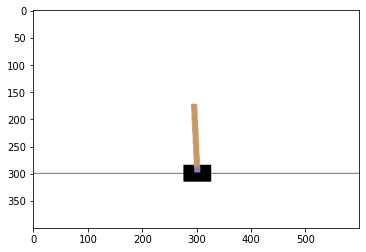

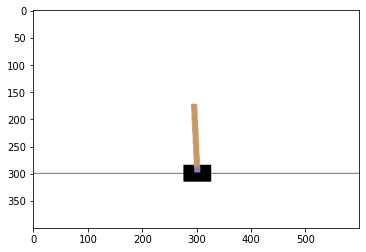

In [ ]:
env = gym.make('CartPole-v1')
env.reset()
visualize(env)

## Построение нейронной сети

In [ ]:
env.observation_space.shape

(4,)

In [ ]:
env.action_space.n

2

Первым делом построим архитектуру сети. Количество нейронов на входном слое - очевидно размерность состояния. Количество нейронов на выходном слое - очевидно количество дейстий. Более никаких ограничений в архитектуре нет - количество скрытых слоев и их функции активации - по вашему усмотрению.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

keras.backend.clear_session()

model = keras.Sequential()
model.add(keras.layers.Dense(128, input_shape=(env.observation_space.shape[0],), activation='relu'))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(env.action_space.n, activation='linear'))
# model.add(keras.layers.Reshape((2,)))

model.summary()
# 11 000
# постройте нейронную сеть, у которой количество входов будет соответствовать размерности пространства наблюдений (4),
# а количество выходов будет соответствовать размерности пространства действий (2)
# в конце выведите информацию о модели

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 2)                 2

Обратите внимание, что импорты у вас могут быть другими! Все зависит отверсий библиотек Tensorflow и Keras. В случае возникновений проблем с импортом, придется немного погуглить.

Инициализируем гиперпараметры

In [ ]:
n_games = 300 # количество игр
gamma = 0.9 # коэффициент дисконтирования
epsilon = 1  # эпсилон (как в предыдущей ЛР)
min_epsilon = 0.01 # минимальное значение эпсилон
epsilon_decay = 0.99 # величина, в которую будем уменьшать эпсилон (в прошлой ЛР был подход с вычитанием)
batch_size = 256 # размер пакета состояний, на котором будем обучать нейронку
learning_rate = 0.01 # скорость обучения нейросети
memory_size = 10000 # размер кратковременной памяти

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss='mse', optimizer=optimizer)

# скомпилируйте модель - выберите предпочитаемый оптимизатор (должен быть на базе sgd)
# в качестве функции потерь допускается любая метрика для решения задачи регресии (нейросеть предсказывает показатели полезности)

## Реализация памяти

Метод DQN основан на использовании кратковременной памяти - наша сеть будет обучаться не на всех возможных парах (состояние, действие), а только на случайным образом выбраных batch_size из всей кратковременной памяти.

Кратковременная память в классическом варианте реализуется как двунаправленная очередь.

За счет такой реализации на каждом шаге каждогго эпизода мы будем записывать в кратковременную память информацию, которая необходима будет для обучения нашей сети. После каждой законченной игры мы будем производить обучение.

Идея двунаправленной очереди - когда памть заполняется, первые вошедшие в нее элементы удаляются. Таким образом, выбирая случайным образом batch_size элементов из постоянно изменяющейся памяти мы будем обеспечивать обучение сети на различных данных.

In [ ]:
from collections import deque

memory = deque(maxlen=memory_size) # создайте двустороннюю очередь с заданным размером memory_size

In [ ]:
memory

deque([])

Реализуем методы для работы с памятью

In [ ]:
def remember(state, action, reward, next_state, done):
  # реализуйте добавление в память кортежа из переданных данных
  memory.append((state, action, reward, next_state, done))

In [ ]:
test_deque = deque([1, 2, 3, 4, 5], maxlen=5)
test_deque.append(6)
# test_deque[1:2]

In [ ]:
import random

def replay():
  x_batch, y_batch = [], []
  batch = random.sample(memory, batch_size) if len(memory) > batch_size else list(memory) # выберите случайным образом batch_size или кортежей из памяти. Если кортежей в памяти меньше чем batch_size - выберите все кортежи
  for state, action, reward, next_state, done in batch:
    y_target = model.predict(state, verbose=0) # получите предсказание модели для данного состояния state
    # print(y_target)
    y_target[0][action] = reward if done else reward + gamma * max(model.predict(next_state, verbose=0)[0])
    # обновите значение y_target[0][action] - если игра окончена, то в качестве значения поставьте текущую награду на данном шаге
    # если игра не окончена, то сделайте предсказание и поставьте в качестве значения произведение gamma и предсказанного сетью
    # максимального значения полезности

    x_batch.append(state[0])
    y_batch.append(y_target[0])
  # обучите модель на всех парах данных из (state[0], y_target[0])
  # print('x: ', x_batch, 'y: ', y_batch)
  model.fit(np.array(x_batch), np.array(y_batch), verbose=0)
  # model.fit(x_batch, y_batch, verbose=0)

In [ ]:
# массив оценок
zxc = []

for game in range(n_games): 
  state = env.reset()
  current_state = np.reshape(state, (1, env.observation_space.shape[0]))  # измените размерность на (1, 4)
  t = 0
  while True:
    # получите current_action пользуясь epsilon-жадной стратегией (используйте предсказания нейросети для текущегосостояния)
    current_action = random.randrange(env.action_space.n) if epsilon > np.random.uniform(0, 1) else np.argmax(model.predict(current_state, verbose=0)[0])

    next_state, reward, done, info = env.step(current_action)
    next_state = np.reshape(next_state, (1, env.observation_space.shape[0]))  # измените размерность на (1, 4)
    # запомните информацию, добавьте ее в память
    remember(current_state, current_action, reward, next_state, done)

    current_state = next_state
    t += 1
    if done:
      print(f"Игра: {game}, Эпсилон: {epsilon}, Награда за игру: {t}")
      zxc.append(t)
      break
  replay()
  epsilon = epsilon * epsilon_decay if epsilon > min_epsilon else min_epsilon
# произведите обучение сети, помните о реализованном подходе с памятью
# обновите значение эпсилон с помощью умножения. Следите за минимальным значением эпсилон

Игра: 0, Эпсилон: 1, Награда за игру: 16
Игра: 1, Эпсилон: 0.99, Награда за игру: 10
Игра: 2, Эпсилон: 0.9801, Награда за игру: 12
Игра: 3, Эпсилон: 0.9702989999999999, Награда за игру: 24
Игра: 4, Эпсилон: 0.96059601, Награда за игру: 11
Игра: 5, Эпсилон: 0.9509900498999999, Награда за игру: 14
Игра: 6, Эпсилон: 0.9414801494009999, Награда за игру: 36
Игра: 7, Эпсилон: 0.9320653479069899, Награда за игру: 21
Игра: 8, Эпсилон: 0.92274469442792, Награда за игру: 15
Игра: 9, Эпсилон: 0.9135172474836407, Награда за игру: 20
Игра: 10, Эпсилон: 0.9043820750088043, Награда за игру: 17
Игра: 11, Эпсилон: 0.8953382542587163, Награда за игру: 51
Игра: 12, Эпсилон: 0.8863848717161291, Награда за игру: 15
Игра: 13, Эпсилон: 0.8775210229989678, Награда за игру: 11
Игра: 14, Эпсилон: 0.8687458127689781, Награда за игру: 35
Игра: 15, Эпсилон: 0.8600583546412883, Награда за игру: 39
Игра: 16, Эпсилон: 0.8514577710948754, Награда за игру: 16
Игра: 17, Эпсилон: 0.8429431933839266, Награда за игру: 24
И

In [ ]:
zxc = np.array(zxc)
print(f'Процент "успешных" прохождений: {(len(zxc[zxc > 100]) / len(zxc)) * 100}%')

Процент "успешных" прохождений: 69.33333333333334%


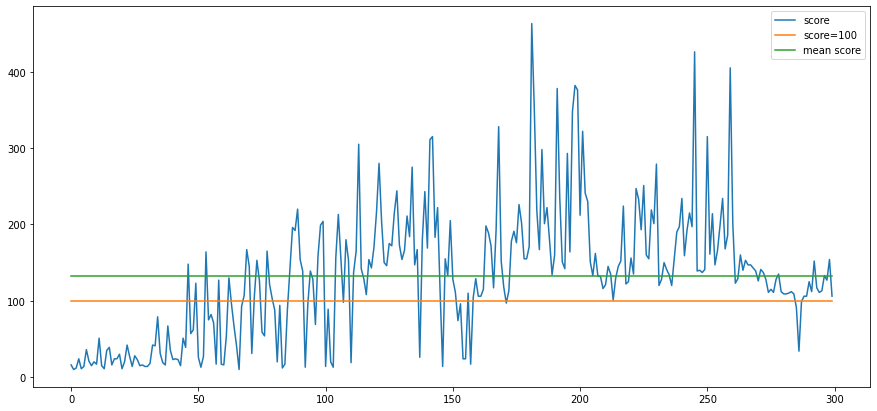

In [ ]:
m = zxc.mean()
plt.figure(figsize=(15, 7))
plt.plot(zxc, label='score')
plt.plot([100 for _ in zxc], label='score=100')
plt.plot([m for _ in zxc], label='mean score')
plt.legend()

### конкурс конкурс конкурс !

In [ ]:
# реплей закомменирован потому что учиться нам не нужно больше
# епсилон тоже закомменитрован потому что жадную стратегию убрали
# ремембер тоже закомменитрован потому что
  # данные для обучения уже не надо сохранять

# массив оценок
scores = []

for game in range(200): 
  state = env.reset()
  current_state = np.reshape(state, (1, env.observation_space.shape[0]))
  t = 0
  while True:
    current_action = np.argmax(model.predict(current_state, verbose=0)[0])

    next_state, reward, done, info = env.step(current_action)
    next_state = np.reshape(next_state, (1, env.observation_space.shape[0]))
    # remember(current_state, current_action, reward, next_state, done)

    current_state = next_state
    t += 1
    if done:
      print("Игра: {:0>3d}\tНаграда за игру: {}".format(game, t))
      scores.append(t)
      break
  # replay()
  # epsilon = epsilon * epsilon_decay if epsilon > min_epsilon else min_epsilon

Игра: 000	Награда за игру: 117
Игра: 001	Награда за игру: 116
Игра: 002	Награда за игру: 108
Игра: 003	Награда за игру: 110
Игра: 004	Награда за игру: 113
Игра: 005	Награда за игру: 101
Игра: 006	Награда за игру: 104
Игра: 007	Награда за игру: 101
Игра: 008	Награда за игру: 108
Игра: 009	Награда за игру: 117
Игра: 010	Награда за игру: 112
Игра: 011	Награда за игру: 114
Игра: 012	Награда за игру: 106
Игра: 013	Награда за игру: 103
Игра: 014	Награда за игру: 104
Игра: 015	Награда за игру: 114
Игра: 016	Награда за игру: 108
Игра: 017	Награда за игру: 120
Игра: 018	Награда за игру: 116
Игра: 019	Награда за игру: 105
Игра: 020	Награда за игру: 99
Игра: 021	Награда за игру: 118
Игра: 022	Награда за игру: 111
Игра: 023	Награда за игру: 118
Игра: 024	Награда за игру: 110
Игра: 025	Награда за игру: 114
Игра: 026	Награда за игру: 107
Игра: 027	Награда за игру: 117
Игра: 028	Награда за игру: 112
Игра: 029	Награда за игру: 103
Игра: 030	Награда за игру: 125
Игра: 031	Награда за игру: 98
Игра: 032	

In [ ]:
scores = np.array(scores)
print(f'Процент "успешных" прохождений: {(len(scores[scores > 100]) / len(scores)) * 100}%')

Процент "успешных" прохождений: 93.0%


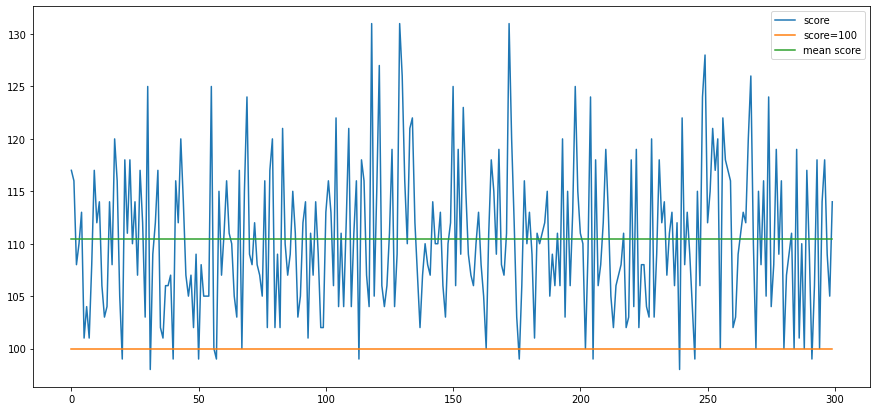

In [ ]:
m = scores.mean()
plt.figure(figsize=(15, 7))
plt.plot(scores, label='score')
plt.plot([100 for _ in scores], label='score=100')
plt.plot([m for _ in scores], label='mean score')
plt.legend()

Как видно, при данных параметрах, агенту удалось обучиться в большинстве случаев получать награду больше 100. Это означает, что в течение более чем 100 шагов стержень балансирует на тележке.

Тем не менее, присутствует фактор случайности. А также сохраняется разброс значений, который можно устранить дополнитльным подбором гиперпараметров и пересмотром архитектуры нейронной сети.

## Задания лабораторной работы

### Основные задания

1. Заполнить пропуски в ячейках, добиться рабочего кода для метода DQN. <b> 6 баллов </b>
<br /><br />
Итого за лабораторную работу: 6 баллов.

### Дополнительные задания

1. Решить любое из игровых окружений окружений Atari (https://www.gymlibrary.dev/environments/atari/complete_list/) с помощью сверточной нейронной сети. В этих окружениях состояния - это отдельные кадры. <b>4 балла</b>

2. Решить любое окружение с использованием keras-rl и DQNAgent. <b>2 балла</b>

### Замечания

1. Выполнять задания можно в Google Colab или локально в среде Jupiter Notebook. При выполнении задания локально не требуется настройка и установка зависимостей для виртуального дисплея (и использование кастомной функции visualize). При вызове метода env.render создастся окно с визуализацией.